Input std: 0.9875565681761207
Output std: 0.3123243143475987


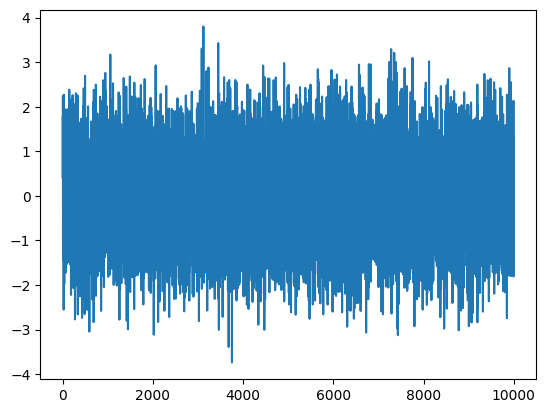

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, cheby1
from scipy.signal import dimpulse
import matplotlib.pyplot as plt

# Generate Gaussian noise
np.random.seed(0)
N = 10000
x = np.random.normal(0, 1, N)

# Design Butterworth filter
b, a = cheby1(N=4, Wn=0.6)  # 4th order low-pass

# Apply filter
y = lfilter(b, a, x)

# Compare std deviations
print("Input std:", np.std(x))
print("Output std:", np.std(y))

# Suppose we have b, a from a filter design
n = 100  # Number of samples of impulse response
_, h = dimpulse((b, a, 1), n=n)
h = np.squeeze(h)  # Convert from nested list
plt.plot(x)


65822353795.835144
200000000000.0


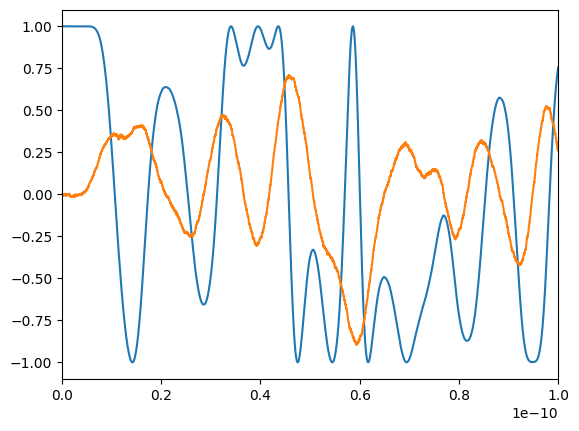

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, fftfreq

# === Parameters ===
fs = 1e14             # Sampling frequency (Hz)
T = 1000e-12                # Total duration (s)
N = int(T * fs)           # Number of samples
t = np.arange(N) / fs     # Time array
f0 = 193e12               # Carrier frequency (Hz)
linewidth = 0.2e12          # Lorentzian FWHM (Hz)

# === Phase noise model: Brownian motion ===
# Phase variance grows linearly with time: var(phi) = π * linewidth * t
# So, each time step gets Gaussian noise with std ~ sqrt(Δt * π * linewidth)
delta_phi_std = np.sqrt(2*np.pi * linewidth / fs)
dphi = np.random.randn(N) * delta_phi_std


# Choose window size (larger = smoother, lower cutoff frequency)
window_size = 1000

# Hamming window
window = np.hamming(window_size)

# Normalize the window to preserve signal amplitude
window /= np.sum(window)
dphi = np.convolve(window, dphi)

phi = np.cumsum(dphi)[:N]  # Integrate to get phase

# === Generate signal: constant amplitude with noisy phase ===
E_t = np.exp(1j * (phi))

# === Compute spectrum ===
E_f = fftshift(fft(E_t))
freqs = fftshift(fftfreq(N, 1/fs))

# === Power spectral density (normalized) ===
psd = np.abs(E_f) ** 2
psd /= np.max(psd)  # Normalize for plotting

# plt.plot(freqs,psd)
plt.plot(t, E_t.real)
plt.xlim(0, 1e-10)
t_mid = t[:-1] + np.diff(t) / 2

instantaneous_phase = np.unwrap(np.angle(E_t))
instantaneous_frequency = np.diff(instantaneous_phase)*fs/(2*np.pi)
# plt.plot(t, instantaneous_phase)
plt.plot(t_mid, instantaneous_frequency/np.max(instantaneous_frequency))
plt.xlim(0, 1e-10)
print(np.std(instantaneous_frequency))
print(linewidth)

(-100000000000000.0, 100000000000000.0)

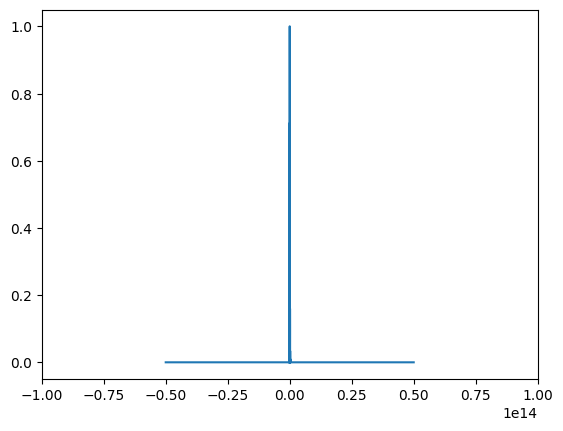

In [2]:
plt.plot(freqs, psd)
# plt.plot(f_theory, psd_theory)
plt.xlim(-1e14, 1e14)

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 5e-11)

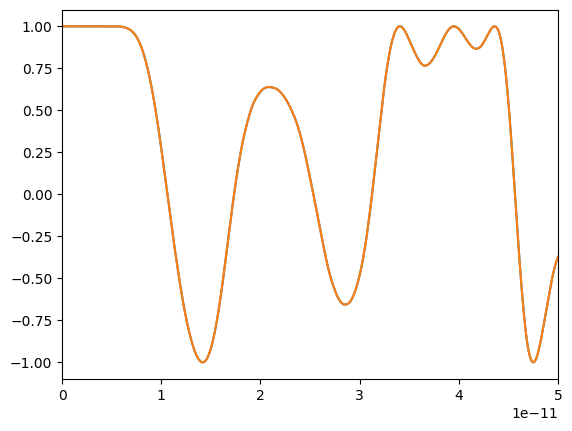

In [3]:
E_t_reconstructed = np.cos(2*np.pi*np.cumsum(instantaneous_frequency) * (t[1] - t[0]))
plt.plot(t, E_t)
plt.plot(t_mid, E_t_reconstructed)
plt.xlim(0, 5e-11)

(0.0, 5e-11)

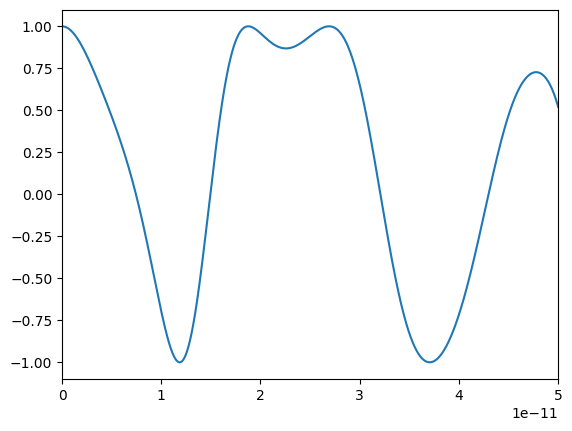

In [4]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt

sigma_1 = 1
sigma_2 = 500
gaussian_noise = np.random.normal(0, sigma_1, N)


f_instantaneous = 2*gaussian_filter1d(gaussian_noise, sigma=sigma_2)
f_instantaneous *= (linewidth/2.355)/np.std(f_instantaneous)


E_t_reconstructed = np.cos(2*np.pi*np.cumsum(f_instantaneous) * (t[1] - t[0]))



plt.plot(t, E_t_reconstructed)
plt.xlim(0, 5e-11)


In [864]:
print(np.std(f_instantaneous))
print(linewidth/2.35)

84925690021.23143
85106382978.7234


In [865]:
t

array([0.0000e+00, 1.0000e-14, 2.0000e-14, ..., 9.9997e-10, 9.9998e-10,
       9.9999e-10], shape=(100000,))

(-10000000000000.0, 10000000000000.0)

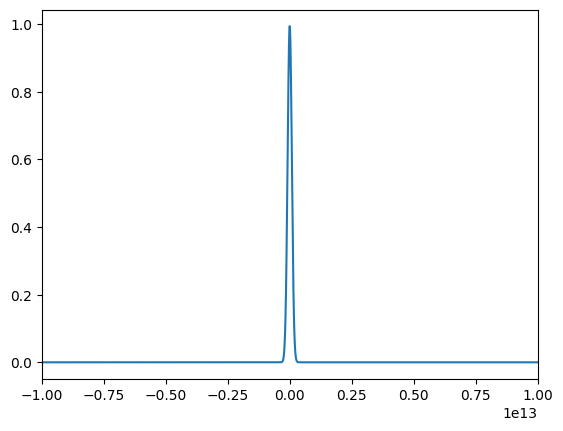

In [866]:
import numpy as np
import matplotlib.pyplot as plt

dt=1e-14
# linewidth = 2e12
f_theory = np.linspace(-10e12, 10e12, 1000)
psd_theory = np.exp(-4*np.log(2)*f_theory**2 / linewidth**2)
plt.plot(f_theory, psd_theory)
plt.xlim(-1e13, 1e13)

(-1000000000000.0, 1000000000000.0)

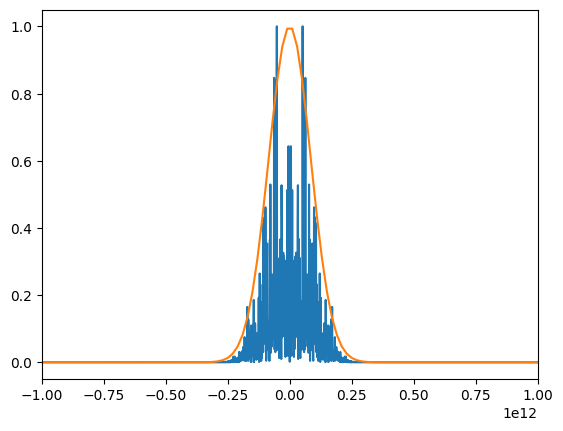

In [867]:
# === Compute spectrum ===
E_f = fftshift(fft(E_t_reconstructed))
freqs = fftshift(fftfreq(N, 1/fs))

# === Power spectral density (normalized) ===
psd = np.abs(E_f) ** 2
psd /= np.max(psd)  # Normalize for plotting

plt.plot(freqs, psd)
plt.plot(f_theory, psd_theory)
plt.xlim(-1e12, 1e12)

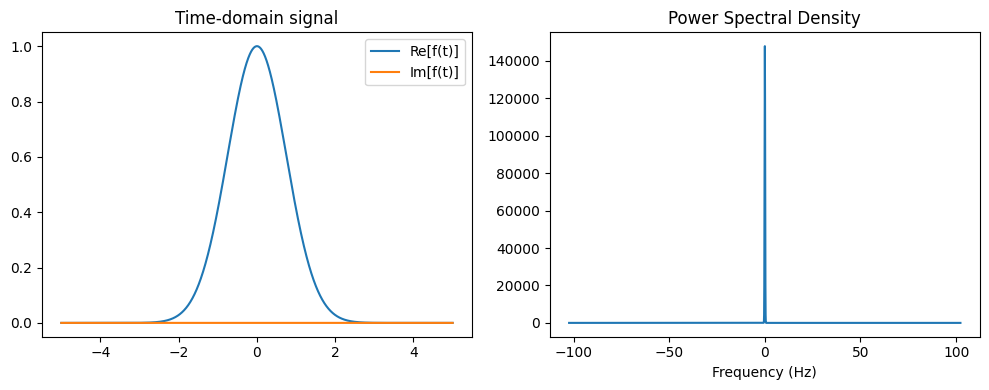

In [159]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_psd_signal(t, nu_fwhm, nu0=0.0):
    sigma_nu = nu_fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to std dev
    sigma_t = 1 / (2 * np.pi * sigma_nu)               # Time-domain std dev
    f_t = np.exp(-t**2 / (2 * sigma_t**2)) * np.exp(2j * np.pi * nu0 * t)
    return f_t

# Example usage
t = np.linspace(-5, 5, 2048)  # Time vector
nu_fwhm = 0.5                 # Desired linewidth in Hz
nu0 = 0.0                     # Center frequency

f_t = gaussian_psd_signal(t, nu_fwhm, nu0)

# Compute FFT and PSD
F_nu = np.fft.fftshift(np.fft.fft(f_t))
freq = np.fft.fftshift(np.fft.fftfreq(len(t), d=(t[1] - t[0])))
psd = np.abs(F_nu)**2

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, np.real(f_t), label='Re[f(t)]')
plt.plot(t, np.imag(f_t), label='Im[f(t)]')
plt.title("Time-domain signal")
plt.legend()

plt.subplot(1,2,2)
plt.plot(freq, psd)
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (2047,) and (9999,)

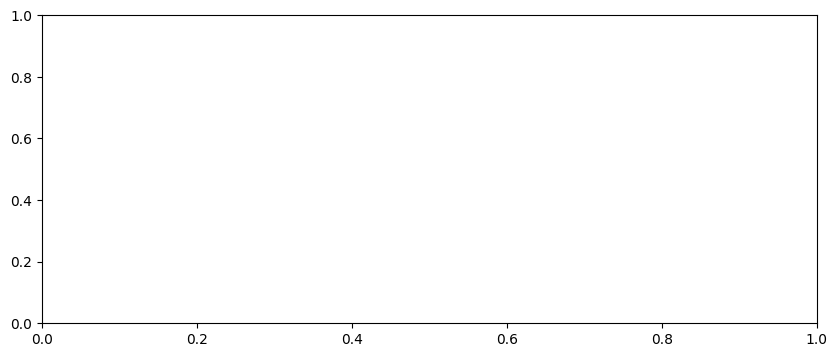

In [160]:
from scipy.signal import hilbert
analytic_signal = hilbert(np.real(E_t))
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
inst_freq = np.diff(instantaneous_phase) * fs / (2.0 * np.pi)
t_mid = t[:-1] + np.diff(t) / 2  # Midpoints for frequency values
# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_mid, inst_freq)
plt.plot(t[:99999], np.diff(np.unwrap(np.angle(E_t)))*fs/(2*np.pi))
plt.xlabel("Time (s)")
plt.ylabel("Instantaneous Frequency (Hz)")
plt.title("Instantaneous Frequency vs Time")
plt.grid(True)
plt.show()
E_t

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 2**14
fs = 1000  # sampling rate in Hz
t = np.linspace(-N/2, N/2, N) / fs
f = np.fft.fftfreq(N, d=1/fs)
f = np.fft.fftshift(f)

# Define Gaussian magnitude spectrum centered at 0
sigma = 30  # frequency domain std dev in Hz
S_f_mag = np.exp(-f**2 / (2 * sigma**2))

# Add random phase
random_phase = np.exp(1j * 2 * np.pi * np.random.rand(N))
S_f = S_f_mag * random_phase

# Shift and invert to time domain
S_f = np.fft.ifftshift(S_f)
s_t = np.fft.ifft(S_f)
s_t = np.real(s_t)
plt.figure(figsize=(12,4))
plt.plot(t, np.abs(s_t))
plt.title("Time-domain signal with Gaussian spectrum")
plt.xlabel("Time (s)")

plt.figure(figsize=(12,4))
plt.plot(f, np.abs(np.fft.fftshift(np.fft.fft(s_t)))**2)
plt.title("Power Spectrum of s(t)")
plt.xlabel("Frequency (Hz)")


In [ ]:


def structure_function(f, max_lag=None):
    """
    Compute the second-order structure function of a 1D time series f(t)
    
    Parameters:
    - f: 1D numpy array of the signal
    - max_lag: maximum lag τ to compute the structure function (default: len(f)//2)

    Returns:
    - D: structure function values for each τ
    """
    f = np.asarray(f)
    N = len(f)
    if max_lag is None:
        max_lag = N // 2
    
    D = np.zeros(max_lag)
    for tau in range(1, max_lag):
        diffs = f[:-tau] - f[tau:]
        D[tau] = 0.5 * np.mean(diffs**2)
    return D

import numpy as np
from numpy.fft import fft, ifft

def quadratic_autocorr(tau, sigma, k):
    R = np.zeros_like(tau, dtype=float)
    inside = np.abs(tau) <= np.max(tau)
    R[inside] = sigma**2 - 1 / k *tau[inside]**2
    return R

def simulate_gaussian_process(n, dt=1.0, sigma=1.0, k=0.1):
    """
    Simulates a stationary Gaussian process with a Gaussian autocovariance function
    using the Shinozuka-Deodatis spectral method.
    
    Parameters:
        n     : number of desired time points
        dt    : time step
        sigma : standard deviation of the process
        ell   : correlation length (controls width of the autocovariance)
    
    Returns:
        t : time vector
        x : simulated Gaussian process
    """
    m = 2 * n  # For circulant embedding

    # Time vector for autocovariance
    taus = dt * np.arange(0, m)
    R = quadratic_autocorr(np.concatenate([taus[:n], -taus[n:]]), sigma, k)

    # FFT to get eigenvalues (power spectrum)
    lam = np.real(fft(R))
    lam = np.maximum(lam, 0)  # Force non-negativity

    # Generate frequency domain coefficients a(j)
    a = np.zeros(m, dtype=complex)
    a[0] = np.sqrt(lam[0] / m) * np.random.randn()
    a[m//2] = np.sqrt(lam[m//2] / m) * np.random.randn()

    for j in range(1, m//2):
        Uj, Vj = np.random.randn(2)
        a[j] = (np.sqrt(lam[j] / (2*m)) * (Uj + 1j*Vj))
        a[m - j] = np.conj(a[j])  # Hermitian symmetry

    # Inverse FFT to get real-valued time-domain signal
    x_full = np.real(ifft(a))
    t = np.arange(n) * dt
    return t, x_full[:n]

In [ ]:
N=20000
dt=0.1
t, phi = simulate_gaussian_process(N, dt=dt, sigma=1e5, k=0.0001)
plt.plot(t, phi)

In [ ]:
# phi = np.cumsum(phi/1000)
phi = np.cumsum(phi/1000)
sf = structure_function(phi)
plt.plot(t[:N//2], sf)
# plt.plot(t, t**2)
# plt.xlim(0, 10)

In [ ]:
x = np.exp(1j*phi)
# x = np.exp(1j*phi/1)
plt.plot(x.real)
plt.plot(x.imag)

In [ ]:
f = np.fft.fftfreq(N, d=dt)
x_f = np.fft.fft(x)
psd = np.abs(x_f)**2
psd = psd / np.max(psd)

f_theory = np.linspace(-2, 2, 10000)
psd_theory = np.exp(-f_theory**2 / 0.000045)

plt.plot(f, psd)
plt.plot(f_theory, psd_theory)
plt.xlim(-0.22, 0.28)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky

def quadratic_autocorr(tau, a):
    R = np.zeros_like(tau, dtype=float)
    inside = np.abs(tau) <= np.max(tau)
    R[inside] = 1 - a * tau[inside]**2
    return R

def simulate_signal_quadratic_acf(N=5, a=0.00001, tau_max=50, seed=0):
    np.random.seed(seed)
    t = np.arange(N)
    taus = np.arange(N)
    
    # Build autocorrelation vector (symmetric, for Toeplitz matrix)
    R = quadratic_autocorr(taus, a=a)

    # Build Toeplitz covariance matrix
    C = toeplitz(R)

    # Check if it's positive semi-definite
    eigvals = np.linalg.eigvalsh(C)
    if np.any(eigvals < -1e-10):
        print("Warning: Covariance matrix is not positive semi-definite.")
        print(f"Minimum eigenvalue: {np.min(eigvals)}")
    
    # Regularize if necessary (add jitter)
    jitter = 1e-10
    try:
        L = cholesky(C + jitter * np.eye(N), lower=True)
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix not positive definite. Try reducing 'a' or increasing jitter.")
    
    z = np.random.randn(N)
    f = L @ z
    return t, f, R

# Simulate
t, f, R = simulate_signal_quadratic_acf(N=1024, a=1e-4)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, f)
plt.title("Simulated Real Signal with Quadratic Autocorrelation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(R[:200])
plt.title("Autocorrelation Function R(τ) = 1 - aτ²")
plt.xlabel("τ")
plt.ylabel("R(τ)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
R = quadratic_autocorr(np.linspace(0, 100), 1e-6)
plt.plot(R)